In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
%matplotlib inline

In [ ]:
import sys

In [109]:
#sys.path.pop(1)
dataset = 'bunny_data/'
dir_basis = '/home/divserge/Desktop/' + dataset

#

## Extracting visual features

In [174]:
#dir_basis = './' + dataset
dir_masks = dir_basis + 'silhouettes/'
dir_images = dir_basis + 'images/'
dir_proj = dir_basis + 'calib/'

#files = sorted([file for file in os.listdir(dir_basis) if file.split('.')[-2] == 'color' 
#                and file.split('.')[-1] == 'png'])[::20]
files = sorted([file for file in os.listdir(dir_images) if file.split('.')[-1] == 'ppm'])
masks = sorted(os.listdir(dir_masks))

def create_orb_features(dir_basis, files):
    for i, file in enumerate(files):

        filename = dir_images + file
        maskname = dir_masks + masks[i]
        
        if os.path.exists(filename[:-3] + 'pckl'):
            continue

        img = (255 - cv.imread(maskname)) * cv.imread(filename)
        gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
        orb = cv.xfeatures2d.SIFT_create()

        kp, descriptors = orb.detectAndCompute(gray, None)

        temp = [(point.pt, point.size, point.angle, point.response, point.octave, 
            point.class_id, desc) for point, desc in zip(kp, descriptors)]

        with open(filename[:-3] + 'pckl', 'wb') as file:
            pickle.dump(temp, file)

In [175]:
create_orb_features(dir_basis, files)

In [176]:
def deserialize_keypoint(point):
    return cv.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], 
                            _response=point[3], _octave=point[4], _class_id=point[5]), point[6]

In [177]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params,search_params)

In [178]:
flann = cv.FlannBasedMatcher(index_params, {})

In [179]:
def get_keypoints(image_file):
    kp1, desc1 = [], []
    with open(image_file[:-3] + 'pckl', 'rb') as file:
        for entry in pickle.load(file):
            k, d = deserialize_keypoint(entry)
            kp1.append(k)
            desc1.append(d)       
    return kp1, np.array(desc1)

In [180]:
fname1 = dir_images + files[0]
fname2 = dir_images + files[1]
kp1, desc1 = get_keypoints(fname1)
kp2, desc2 = get_keypoints(fname2)

## Descriptors matching

In [181]:
matches = flann.knnMatch(desc1,desc2,k=2)

In [182]:
matchesMask = [[0,0] for i in range(len(matches))]

good = []
pts1 = []
pts2 = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i] = [1, 0]
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [183]:
draw_params = {
    'matchColor' : (0,255,0),
    'singlePointColor' : (255,0,0),
    'matchesMask' : matchesMask,
    'flags' : 0
}

In [184]:
img1 = cv.imread(fname1)
img2 = cv.imread(fname2)

In [185]:
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None, **draw_params)

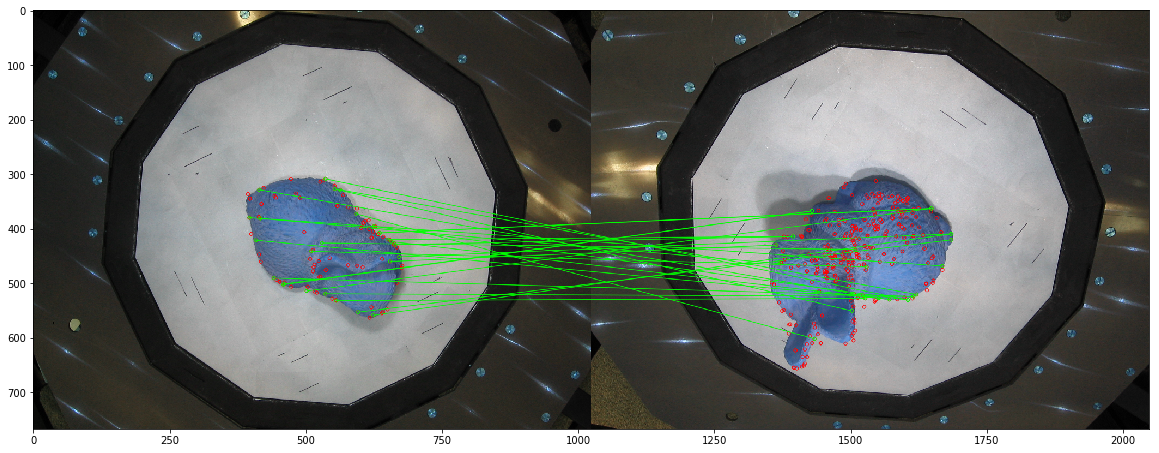

In [186]:
plt.figure(figsize=(20, 10))
plt.imshow(img3)

In [187]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [188]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, _ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv.circle(img2,tuple(pt2),5,color,-1)
    return img1, img2

## Filtering out false matches with Epipolar geometry

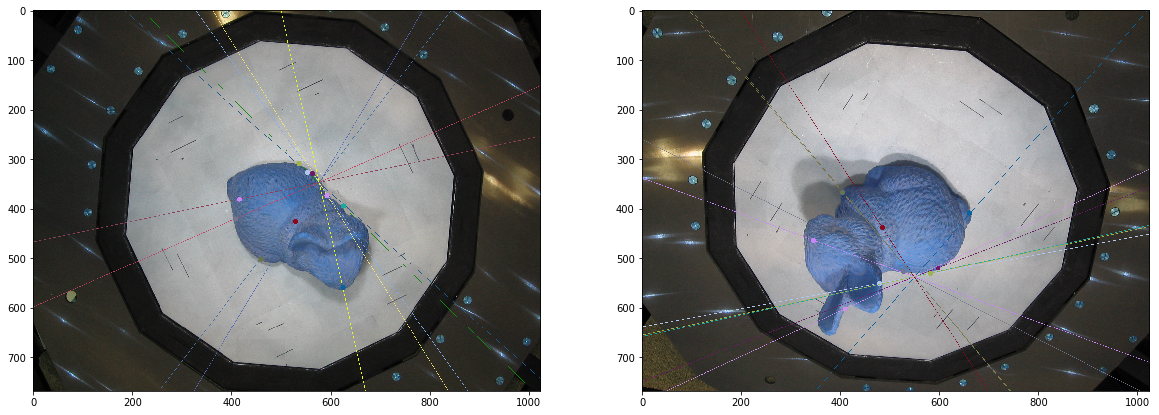

In [189]:
plt.figure(figsize=(20, 10))
lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
plt.subplot(121), plt.imshow(img5)
plt.subplot(122), plt.imshow(img3)
plt.show()

In [190]:
P = np.loadtxt(dir_proj + files[0].split('.')[0] + '.txt', skiprows=1)

In [191]:
from itertools import product

K = cv.sfm.KRtFromProjection(P)[0]
calibrations = [K]

def find_correspondences(files):
    # TODO: Save fundamental matrices
    # How to take out 
    
    fname0 = files[0]
    kp0, desc0 = get_keypoints(fname0)
    pts_correspondence = {}

    for i in range(len(files))[1:]:

        fname1 = files[i]
        kp1, desc1 = get_keypoints(fname1)

        flann = cv.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc0,desc1,k=2)

        matchesMask = [[0,0] for i in range(len(matches))]

        good = []
        pts1 = []
        pts2 = []

        # ratio test as per Lowe's paper
        for j, p in enumerate(matches):
            try:
                m, n = p
            except:
                continue
            if m.distance < 0.8 * n.distance:
                matchesMask[j] = [1, 0]
                good.append(m)
                pts2.append(kp1[m.trainIdx])
                pts1.append(kp0[m.queryIdx])

        pts1_coord = np.int32([kp.pt for kp in pts1])
        pts2_coord = np.int32([kp.pt for kp in pts2])

        F, mask = cv.findFundamentalMat(pts1_coord, pts2_coord, cv.FM_RANSAC)
        
        pts1 = np.array(pts1)[mask.ravel() == 1]
        pts2 = np.array(pts2)[mask.ravel() == 1]
        
        pts1_coord = pts1_coord[mask.ravel() == 1]
        pts2_coord = pts2_coord[mask.ravel() == 1]
        
        P = np.loadtxt(dir_proj + (files[i].split('.')[-2]).split('/')[-1] + '.txt', skiprows=1)
        K, R, t = cv.sfm.KRtFromProjection(P)
        
        calibrations.append(K)
        
        E, mask = cv.findEssentialMat(pts1_coord, pts2_coord, K)
        T = np.eye(4)
        _, R, t, _ = cv.recoverPose(E, pts1_coord, pts2_coord, K)
        T[:3, :3] = R
        T[:-1, -1] = t.reshape(-1)
        
        pts_correspondence[(i-1, i)] = (pts1.copy(), pts2.copy(), T.copy())

        kp0, desc0 = kp1, desc1
        
    return pts_correspondence

pts_correspondence = find_correspondences([dir_images + file for file in files])

In [192]:
P = np.loadtxt(dir_proj + (files[0].split('.')[-2]).split('/')[-1] + '.txt', skiprows=1)
K, R, t = cv.sfm.KRtFromProjection(P)
T = np.eye(4)
T[:3, :3] = R
T[:-1, -1] = t.reshape(-1)
poses_fake = [T.copy()]

for i in range(len(files) - 1):
    poses_fake.append(pts_correspondence[i, i + 1][-1] @ poses_fake[-1])

In [193]:
poses_true = []
for i in range(len(files)):
    P = np.loadtxt(dir_proj + (files[i].split('.')[-2]).split('/')[-1] + '.txt', skiprows=1)
    K, R, t = cv.sfm.KRtFromProjection(P)
    T = np.eye(4)
    T[:3, :3] = R
    T[:-1, -1] = t.reshape(-1)
    poses_true.append(T.copy())

## Building 3D - points trajectories

In [194]:
tracks = [[True, 0, [pt1, pt2]] for pt1, pt2 in zip(*pts_correspondence[(0, 1)][:-1])]

In [195]:
for i in range(1, len(files) - 1):
    
    if i % 50 == 0:
        print(i)
        print(len(tracks))
        
    taken_points = np.zeros_like(pts_correspondence[(i, i + 1)][0], dtype=bool)
    
    for track in tracks:
        
        has_match = False
        kp = track[-1][-1]
        
        if track[0] == False:
            continue

        for j, kp1 in enumerate(pts_correspondence[(i, i + 1)][0]):
            if np.linalg.norm(np.array(kp.pt) - np.array(kp1.pt)) < kp.size:
                taken_points[j] = True
                if has_match:
                    continue
                has_match = True
                track[-1].append(pts_correspondence[(i, i + 1)][1][j])
        
        track[0] = has_match
    
    for kp_index in np.where(taken_points == False)[0]:
        tracks.append([True, i, [
            pts_correspondence[(i, i + 1)][0][kp_index],
            pts_correspondence[(i, i + 1)][1][kp_index]
        ]])

In [196]:
lengths = [len(track[-1]) for track in tracks]

In [197]:
lengths[np.argmax(lengths)]

8

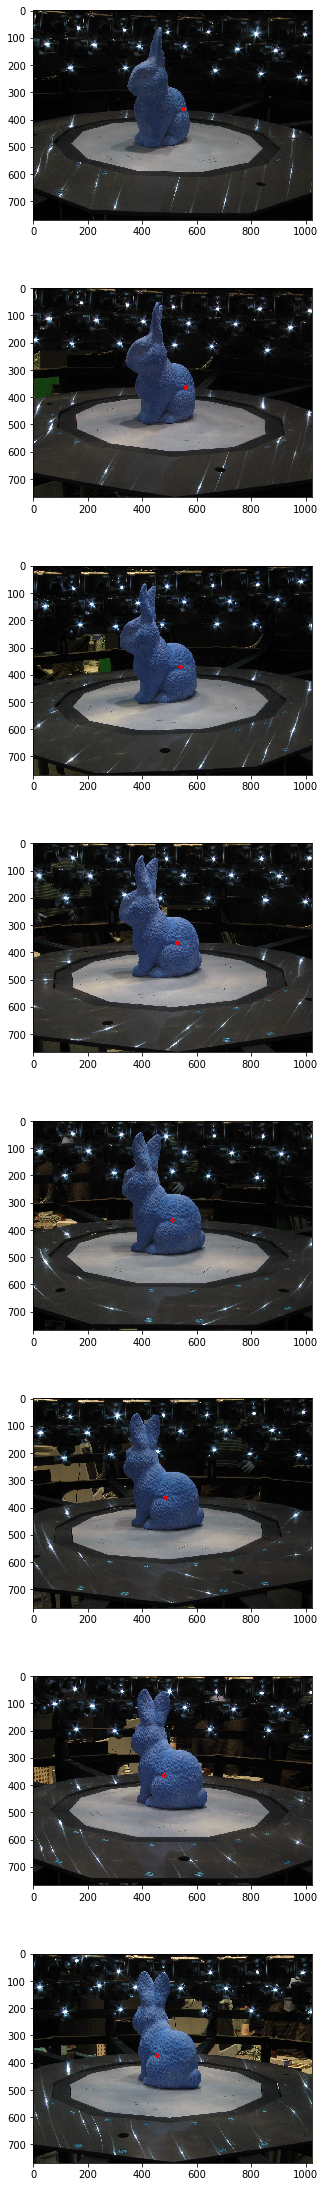

In [198]:
k = np.argmax(lengths)
plt.figure(figsize=(5, len(tracks[k][-1]) * 5))
for j, kp in enumerate(tracks[k][-1]):
    plt.subplot(len(tracks[k][-1]), 1, j + 1)
    i = tracks[k][1]
    im = cv.imread(dir_images + files[i + j])
    cv.circle(im, tuple(np.array(kp.pt, dtype=np.int32)), 5, (255, 0, 0), 5)
    plt.imshow(im)

In [199]:
lengths = [len(track[2]) for track in tracks]
# first entry - finish flag (auxilary stuff)
# second entry - the first frame where the point appears
# third entry - list of keypoints on subsequent images

In [200]:
poses = poses_true

## Triangulating points from the images where they are seen

In [201]:
succesfull_triangulations = {}

for i, track in enumerate(tracks):
    
    if len(track[-1]) < 3:
        continue
    
    image_coords = np.array([kp.pt for kp in tracks[i][-1]])
    image_indices = np.arange(tracks[i][1], tracks[i][1] + len(tracks[i][-1]))
    
    triangulations = []
    
    for j in range(len(image_indices) - 1):
        
        R = poses[image_indices[j]][:3, :3]
        t = poses[image_indices[j]][:-1, -1]
        P = np.eye(4)
        P[:3, :3] = R
        P[:-1, -1] = t
        P = P[:-1, :]
        
        R_dash = poses[image_indices[j + 1]][:3, :3]
        t_dash = poses[image_indices[j + 1]][:-1, -1]
        P_dash = np.eye(4)
        P_dash[:3, :3] = R_dash
        P_dash[:-1, -1] = t_dash
        P_dash = P_dash[:-1, :]
        
        K = calibrations[image_indices[j]]
        K_dash = calibrations[image_indices[j + 1]]
        
        P = K @ P
        P_dash = K_dash @ P_dash
        
        world_point = cv.triangulatePoints(
            P, P_dash,
            image_coords[j].reshape(2, -1), image_coords[j + 1].reshape(2, -1)
        )
        
        world_point = cv.convertPointsFromHomogeneous(world_point.reshape(-1, 4))
        triangulations.append(world_point)
        
    triangulation = np.array(triangulations).mean(axis=0)
    world_point = cv.convertPointsToHomogeneous(triangulation).reshape(-1)
    
    for j in range(len(image_indices)):
        
        R = poses[image_indices[j]][:3, :3]
        t = poses[image_indices[j]][:-1, -1]
        P = np.eye(4)
        P[:3, :3] = R
        P[:-1, -1] = t
        P = P[:-1, :]
        
        K = calibrations[image_indices[j]]
        
        P = K @ P
        
        rep = cv.convertPointsFromHomogeneous(
            (P @ world_point).reshape(-1, 3)
        ).reshape(-1)
        
        if np.linalg.norm(rep - image_coords[j]) > 10:
            break
    else:
        succesfull_triangulations[i] = triangulation.reshape(-1)

In [202]:
len(succesfull_triangulations.keys())

661

## Bundle adjustment

In [205]:
tracks_successfull = [tracks[i] for i in succesfull_triangulations]

In [206]:
points_2d = []
points_ind = []
camera_ind = []

for i, track in enumerate(tracks_successfull):
    for j, kp in enumerate(track[-1]):
        points_ind.append(i)
        camera_ind.append(track[1] + j)
        points_2d.append(kp.pt)
        
points_2d = np.array(points_2d)
point_indices = np.array(points_ind, dtype=np.uint32)
camera_indices = np.array(camera_ind, dtype=np.uint32)

points_3d = np.array([succesfull_triangulations[i] for i in succesfull_triangulations])

camera_params = []
for K, pose in zip(calibrations, poses):
    camera_params.append(list(cv.Rodrigues(pose[:3, :3])[0].ravel()) +
                         list(pose[:-1, -1].ravel()) +
                         [K[0,0], 0, 0]
                        )
camera_params = np.array(camera_params)
n_cameras = camera_params.shape[0]

In [207]:
np.save('points_2d.npy', points_2d)
np.save('point_indices.npy', point_indices)
np.save('camera_indices.npy', camera_indices)
np.save('points_3d.npy', points_3d)
np.save('camera_params.npy', camera_params)

In [208]:
import numpy as np
points_2d = np.load('points_2d.npy')
point_indices = np.load('point_indices.npy')
camera_indices = np.load('camera_indices.npy')
points_3d = np.load('points_3d.npy')
camera_params = np.load('camera_params.npy')
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

In [209]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
        
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [210]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [211]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    a
    `params` contains camera parameters and 3-D coordinates.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

In [212]:
from scipy.sparse import lil_matrix

In [213]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

In [214]:
%matplotlib inline
import matplotlib.pyplot as plt

In [215]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))

In [216]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

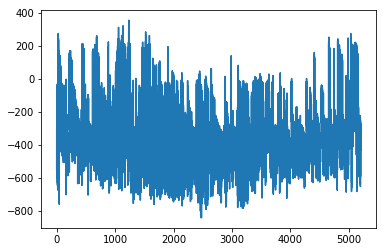

In [217]:
plt.plot(f0)

In [218]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [219]:
import time
from scipy.optimize import least_squares

In [220]:
t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.0838e+08                                    7.25e+06    
       1              4         3.5592e+08      5.25e+07       3.41e+04       5.73e+06    
       2              5         2.6038e+08      9.55e+07       9.35e+02       4.16e+06    
       3              6         8.0424e+07      1.80e+08       1.34e+03       5.77e+06    
       4              8         3.8238e+07      4.22e+07       3.78e+02       3.57e+06    
       5              9         8.3190e+06      2.99e+07       6.91e+02       1.18e+06    
       6             10         4.4623e+06      3.86e+06       3.79e+03       1.76e+06    
       7             12         1.1231e+06      3.34e+06       9.08e+02       4.62e+05    
       8             13         6.9897e+05      4.24e+05       6.38e+02       4.14e+05    
       9             15         4.4558e+05      2.53e+05       1.24e+02       4.81e+05    

      90             122        2.8242e+04      7.40e+01       9.85e+01       3.97e+04    
      91             123        2.8146e+04      9.59e+01       1.91e+02       1.81e+05    
      92             125        2.8075e+04      7.11e+01       9.35e+01       4.17e+04    
      93             126        2.7983e+04      9.18e+01       1.81e+02       1.89e+05    
      94             128        2.7915e+04      6.84e+01       8.89e+01       4.36e+04    
      95             129        2.7826e+04      8.81e+01       1.72e+02       1.97e+05    
      96             131        2.7761e+04      6.57e+01       8.47e+01       4.53e+04    
      97             132        2.7676e+04      8.45e+01       1.64e+02       2.04e+05    
      98             134        2.7613e+04      6.32e+01       8.08e+01       4.70e+04    
      99             135        2.7532e+04      8.12e+01       1.57e+02       2.11e+05    
      100            137        2.7471e+04      6.08e+01       7.73e+01       4.86e+04    

KeyboardInterrupt: 

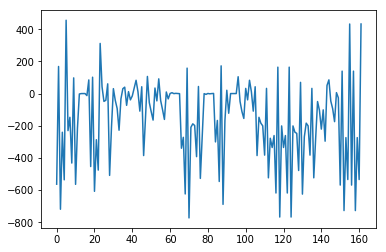

In [104]:
plt.plot(res.fun)

In [105]:
pts = res.x.reshape(-1, 3)

In [106]:
import plotly.graph_objs as go
from  plotly.offline import iplot,init_notebook_mode

def get_plot(x, y, z):
    init_notebook_mode(False)
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=1.0,
            line=dict(
                width=0.5
            ),
            opacity=0.8
        )
    )
    
    layout = go.Layout(
                    scene = dict(
                    xaxis = dict(
                        nticks=4,),
                    yaxis = dict(
                        nticks=4,),
                    zaxis = dict(
                        nticks=4,),),
                    width=700,
                    margin=dict(
                    r=20, l=10,
                    b=10, t=10)
                  )
    fig = go.Figure(data=[trace1], layout=layout)

    return iplot(fig, filename='bla')

cloud = np.array([succesfull_triangulations[key] for key in succesfull_triangulations])
get_plot(pts[:, 0], pts[:, 1], pts[:, 2])

In [127]:
from scipy import sparse

In [129]:
jacobian = res.jac
coordwise_sigmas = np.zeros(2 * len(sigmas))
coordwise_sigmas[2 * np.arange(len(sigmas))] = sigmas
coordwise_sigmas[2 * np.arange(len(sigmas)) + 1] = sigmas
uncertainties = (coordwise_sigmas[:, None] * jacobian.toarray()).T @ jacobian.toarray()

In [130]:
uncertainties.shape

(2751, 2751)